**Task 1-Data Preparation and Customer Analytics Conduct analysis on your client's transaction dataset and identify customer purchasing behaviours to generate insights and provide commercial recommendations.**

Information for the task

We need to present a strategic recommendation to Julia that is supported by data which she can then use for the upcoming category review however to do so we need to analyse the data to understand the current purchasing trends and behaviours. The client is particularly interested in customer segments and their chip purchasing behaviour. Consider what metrics would help describe the customers’ purchasing behaviour.

Main goals of this task are :

1.   Examine transaction data - check for missing data, anomalies, outliers and clean them
2.   Examine customer data - similar to above transaction data
3.   Data analysis and customer segments - create charts and graphs, note trends and insights
4.   Deep dive into customer segments - determine which segments should be targetted  


In [1]:
# Loading required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime 
import seaborn as sns
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.preprocessing import OneHotEncoder

### Loading Data

In [2]:
# Read data file into dataframe
TranData = pd.read_excel(r"C:\Users\NATHAN\Desktop\Data_DS_Projects\Quantium_Virtual_Experience_Program\Dataset\QVI_transaction_data.xlsx")
print(TranData.info())
TranData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB
None


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [3]:
# Change date from xlsx integer dates to date format (DD/MM/YYYY)
TranData['DATE'] = pd.to_datetime(TranData['DATE'], unit='D', origin='1899-12-30')
# check format of replacement date column 
print(TranData['DATE'].dtype) 

datetime64[ns]


In [4]:
# View all unique entries in the product name column 
TranData['PROD_NAME'].unique()

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Kettle Sensations   Siracha Lime 150g',
       'Twisties Cheese     270g', 'WW Crinkle Cut      Chicken 175g',
       'Thins Chips Light&  Tangy 175g', 'CCs Original 175g',
       'Burger Rings 220g', 'NCC Sour Cream &    Garden Chives 175g',
       'Doritos Corn Chip Southern Chicken 150g',
       'Cheezels Cheese Box 125g', 'Smiths Crinkle      Original 330g',
       'Infzns Crn Crnchers Tangy Gcamole 110g',
       'Kettle Sea Salt     And Vinegar 175g',
       'Smiths Chip Thinly  Cut Original 175g', 'K

While it looks like we have chips, we want to check that the products are only chips by counting the word frequencies in the product names. To make this process clearer, we can remove the number and symbols from the names.

In [5]:
# Remove number from the product names
prod_name = TranData['PROD_NAME'].str.replace(r'[0-9]+[gG]','');

# Remove characters from the product names and replace with a space to separate flavours
prod_name = prod_name.str.replace(r'&',' ');

In [6]:
# Count the frequencies of words in product names and display counts in descending order
word_counts = pd.Series(' '.join(prod_name).split()).value_counts()
# show all rows
with pd.option_context('display.max_rows', None): 
  display(word_counts)

175g                  60561
Chips                 49770
150g                  41633
Kettle                41288
Smiths                28860
Salt                  27976
Cheese                27890
Pringles              25102
134g                  25102
Doritos               24962
Crinkle               23960
110g                  22387
Corn                  22063
Original              21560
Cut                   20754
Chip                  18645
170g                  18502
Salsa                 18094
Chicken               15407
Chilli                15390
165g                  15297
Sea                   14145
Thins                 14075
Sour                  13882
Crisps                12607
330g                  12540
Vinegar               12402
300g                  12041
RRD                   11894
Sweet                 11060
Infuzions             11057
Supreme               10963
Chives                10951
Cream                 10723
WW                    10320
Popd                

In [7]:
# Remove salsas from the dataset
TranData =TranData[TranData['PROD_NAME'].str.contains(r"salsa") == False]
# check for a reduction in no of rows
TranData.shape  

(264836, 8)

In [8]:
# Check if there are any nans in the dataset
print(TranData.isnull().sum())
TranData.isnull().values.any()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64


False

Now we do summaries of the TranData (eg min, max, mean) to see if there are any obvious outliers in the data and if there are any nulls in any of the columns.

In [9]:
# Create summaries of the transaction data
TranData.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,264836,264836.00000,2.648360e+05,2.648360e+05,264836.000000,264836.000000,264836.000000
mean,2018-12-30 00:52:12.879215616,135.08011,1.355495e+05,1.351583e+05,56.583157,1.907309,7.304200
min,2018-07-01 00:00:00,1.00000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.500000
25%,2018-09-30 00:00:00,70.00000,7.002100e+04,6.760150e+04,28.000000,2.000000,5.400000
50%,2018-12-30 00:00:00,130.00000,1.303575e+05,1.351375e+05,56.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.00000,2.030942e+05,2.027012e+05,85.000000,2.000000,9.200000
max,2019-06-30 00:00:00,272.00000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000
std,NaN,76.78418,8.057998e+04,7.813303e+04,32.826638,0.643654,3.083226


From the summary, there is at least one transaction with 200 packets. Let's investigate this purchase further.

In [10]:
# Filter the entries that have 200 packets. 
TranData.loc[TranData['PROD_QTY'] == 200.0]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


Two outliers of value 200 in PROD_QTY will be removed. Both entries are by the same customer and will be examined by this customer's transactions

In [11]:
# Remove the transactions
TranData = TranData[TranData['LYLTY_CARD_NBR'] != 226000]
# check for a reduction of 2 rows (i.e. 264834 rows)
TranData.shape 

(264834, 8)

Now look at the number of transaction lines over time to see if there are any obvious data issues such as missing data from particular days.

In [12]:
# Count transactions by date to see if there are any missing days 
count = TranData.groupby(TranData['DATE'].dt.date).size().reset_index(name = 'COUNT')
count.shape

(364, 2)

In [13]:
# There is one day of data missing. First check the range of dates by sorting in time order. 
TranData.sort_values(by='DATE')

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
205333,2018-07-01,24,24109,20881,54,CCs Original 175g,2,4.2
202059,2018-07-01,236,236023,238660,100,Smiths Crinkle Cut Chips Chs&Onion170g,2,5.8
102495,2018-07-01,45,45100,40977,47,Doritos Corn Chips Original 170g,2,8.8
217968,2018-07-01,21,21284,17968,59,Old El Paso Salsa Dip Tomato Med 300g,2,10.2
149892,2018-07-01,262,262188,262373,114,Kettle Sensations Siracha Lime 150g,2,9.2
...,...,...,...,...,...,...,...,...
152885,2019-06-30,26,26054,22482,34,Pringles Slt Vingar 134g,2,7.4
77974,2019-06-30,201,201371,201571,36,Kettle Chilli 175g,2,10.8
51400,2019-06-30,222,222089,222019,114,Kettle Sensations Siracha Lime 150g,2,9.2
132841,2019-06-30,230,230102,232603,52,Grain Waves Sour Cream&Chives 210G,2,7.2


We can see that the dates range from 1 Jul 2018 to 30 Jun 2019. Now we want to check through the year of dates to see which day the data is missing.

In [14]:
# Generate a list of dates with transactions in ascending order 
date_counts = TranData.groupby('DATE').size()

# Then compare to a full list of dates within the same range to find differences between them 
pd.date_range(start = '2018-07-01', end = '2019-06-30' ).difference(date_counts.index)

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

The missing date is Christmas day, a public holiday, so it is expected that there are no sales on this day. Now we move onto creating other features such as the pack size, and checking this for any outliers.

In [15]:
# Add a new column to data with packet sizes and extract sizes from product name column
TranData.insert(8, "PACK_SIZE", TranData['PROD_NAME'].str.extract('(\d+)').astype(float), True)

# Sort by packet sizes to check for outliers 
TranData.sort_values(by='PACK_SIZE')

<>:2: DeprecationWarning: invalid escape sequence '\d'
<>:2: DeprecationWarning: invalid escape sequence '\d'
C:\Users\NATHAN\AppData\Local\Temp\ipykernel_5592\748021525.py:2: DeprecationWarning: invalid escape sequence '\d'
  TranData.insert(8, "PACK_SIZE", TranData['PROD_NAME'].str.extract('(\d+)').astype(float), True)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
168991,2018-11-20,232,232155,236068,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
78107,2018-11-23,207,207153,205497,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
78056,2019-06-08,205,205066,204133,38,Infuzions Mango Chutny Papadums 70g,1,2.4,70.0
247504,2018-07-03,121,121379,124482,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
27670,2019-06-30,230,230174,233107,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
...,...,...,...,...,...,...,...,...,...
57372,2018-10-26,40,40025,36217,4,Dorito Corn Chp Supreme 380g,2,13.0,380.0
115324,2019-05-24,235,235133,238063,14,Smiths Crnkle Chip Orgnl Big Bag 380g,2,11.8,380.0
57373,2018-12-10,40,40025,36218,14,Smiths Crnkle Chip Orgnl Big Bag 380g,2,11.8,380.0
57127,2019-01-03,35,35397,31936,14,Smiths Crnkle Chip Orgnl Big Bag 380g,1,5.9,380.0


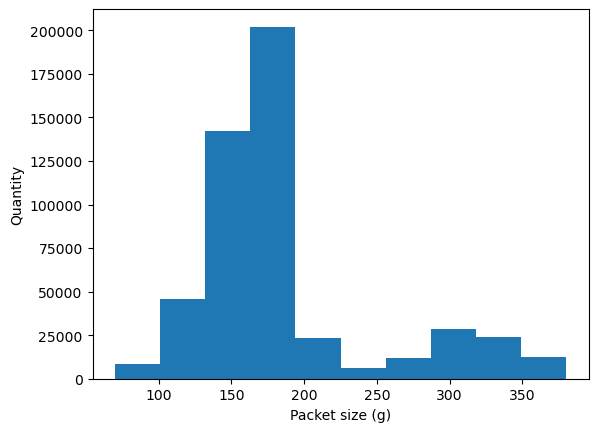

In [16]:
# Minimum packet size is 70g while max is 380g - this is reasonable. 
# Plot a histogram to visualise distribution of pack sizes. 
plt.hist(TranData['PACK_SIZE'], weights=TranData['PROD_QTY']);
plt.xlabel('Packet size (g)');
plt.ylabel('Quantity');

In [17]:
# Add a column to extract the first word of each product name to. 
TranData.insert(9, "BRAND_NAME",TranData['PROD_NAME'].str.split().str.get(0), True)
TranData

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175.0,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170.0,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175.0,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150.0,Kettle
...,...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175.0,Kettle
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175.0,Tostitos
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170.0,Doritos
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150.0,Doritos


In [18]:
# Print all unique entries to check the brand names created
TranData["BRAND_NAME"].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Old', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'Woolworths', 'French', 'RRD', 'Tostitos',
       'Cheetos', 'Snbts', 'Sunbites'], dtype=object)

In [19]:
# Create a function to identify the string replacements needed.
def replace_brandname(line):
    name = line['BRAND_NAME']
    if name == "Infzns":
        return "Infuzions"
    elif name == "Red":
        return "Red Rock Deli"
    elif name == "RRD":
        return "Red Rock Deli"
    elif name == "Grain":
        return "Grain Waves"
    elif name == "GrnWves":
        return "Grain Waves"
    elif name == "Snbts":
        return "Sunbites"
    elif name == "Natural":
        return "Natural Chip Co"
    elif name == "NCC":
        return "Natural Chip Co"
    elif name == "WW":
        return "Woolworths"
    elif name == "Smith":
        return "Smiths"
    elif name == "Dorito":
        return "Doritos"
    else:
        return name 

# Then apply the function to clean the brand names
TranData["BRAND_NAME"] = TranData.apply(lambda line: replace_brandname(line), axis=1)

# Check that there are no duplicate brands 
TranData["BRAND_NAME"].unique()

array(['Natural Chip Co', 'CCs', 'Smiths', 'Kettle', 'Old', 'Grain Waves',
       'Doritos', 'Twisties', 'Woolworths', 'Thins', 'Burger', 'Cheezels',
       'Infuzions', 'Red Rock Deli', 'Pringles', 'Tyrrells', 'Cobs',
       'French', 'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

The brand names looks okay, without duplicates.

In [20]:
# Read data file into dataframe
PurBvr = pd.read_csv(r"C:\Users\NATHAN\Desktop\Data_DS_Projects\Quantium_Virtual_Experience_Program\Dataset\QVI_purchase_behaviour.csv")

print(PurBvr.info())
PurBvr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [21]:
# Rename "PREMIUM_CUSTOMER" to "MEMBER_TYPE" for easier identification of the column data
PurBvr = PurBvr.rename(columns={'PREMIUM_CUSTOMER': 'MEMBER_TYPE'})

In [22]:
PurBvr.describe()

,LYLTY_CARD_NBR
count,7.263700e+04
mean,1.361859e+05
std,8.989293e+04
min,1.000000e+03
25%,6.620200e+04
50%,1.340400e+05
75%,2.033750e+05
max,2.373711e+06


In [23]:
# Check for missing values
PurBvr.isnull().sum()

LYLTY_CARD_NBR    0
LIFESTAGE         0
MEMBER_TYPE       0
dtype: int64

In [24]:
# Check the entries in the member type and lifestage columns
PurBvr["MEMBER_TYPE"].unique()

array(['Premium', 'Mainstream', 'Budget'], dtype=object)

In [25]:
PurBvr["LIFESTAGE"].unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

In [26]:
df = pd.merge(PurBvr, TranData, on = 'LYLTY_CARD_NBR', how = 'right')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   LYLTY_CARD_NBR  264834 non-null  int64         
 1   LIFESTAGE       264834 non-null  object        
 2   MEMBER_TYPE     264834 non-null  object        
 3   DATE            264834 non-null  datetime64[ns]
 4   STORE_NBR       264834 non-null  int64         
 5   TXN_ID          264834 non-null  int64         
 6   PROD_NBR        264834 non-null  int64         
 7   PROD_NAME       264834 non-null  object        
 8   PROD_QTY        264834 non-null  int64         
 9   TOT_SALES       264834 non-null  float64       
 10  PACK_SIZE       264834 non-null  float64       
 11  BRAND_NAME      264834 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 24.2+ MB
None


,LYLTY_CARD_NBR,LIFESTAGE,MEMBER_TYPE,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,Natural Chip Co
1,1307,MIDAGE SINGLES/COUPLES,Budget,2019-05-14,1,348,66,CCs Nacho Cheese 175g,3,6.3,175.0,CCs
2,1343,MIDAGE SINGLES/COUPLES,Budget,2019-05-20,1,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170.0,Smiths
3,2373,MIDAGE SINGLES/COUPLES,Budget,2018-08-17,2,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175.0,Smiths
4,2426,MIDAGE SINGLES/COUPLES,Budget,2018-08-18,2,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150.0,Kettle


In [27]:
# Check for nulls in the df dataset
df.isnull().values.any()

False

In [28]:
# Export df data file to CSV
df.to_csv(r"C:\Users\NATHAN\Desktop\Data_DS_Projects\Quantium_Virtual_Experience_Program\Dataset\QVI_New_data.csv")

## Data analysis on customer segments
Now that the data has been cleaned, we want to look for interesting insights in the chip market to help recommend a business strategy.

To do so, some metrics we want to consider are:

Who spends the most on chips (total sales), describing customers by lifestage and how premium their general purchasing behaviour is,
How many customers are in each segment,
How many chips are bought per customer by segment,
What's the average chip price by customer segment,

The customer’s total spend over the period and total spend for each transaction to understand what proportion of their grocery spend is on chips.
Spending on other snacks, such as crackers and biscuits, to determine the preference and the purchase frequency of chips compared to other snacks
Proportion of customers in each customer segment overall to compare against the mix of customers who purchase chips
Firstly, we will look at the split of the total sales by LIFESTAGE and MEMBER_TYPE.

In [29]:
# calculate total sales by lifestage and member type and generate a list  
total_sales_cust = df.groupby(['LIFESTAGE','MEMBER_TYPE'], as_index = False)['TOT_SALES'].agg(['sum'])
total_sales_cust = total_sales_cust.rename(columns={'sum': 'sum_tot_sales'})
total_sales_cust.sort_values(by = "sum_tot_sales", ascending = False)

,LIFESTAGE,MEMBER_TYPE,sum_tot_sales
6,OLDER FAMILIES,Budget,168363.25
19,YOUNG SINGLES/COUPLES,Mainstream,157621.60
13,RETIREES,Mainstream,155677.05
15,YOUNG FAMILIES,Budget,139345.85
9,OLDER SINGLES/COUPLES,Budget,136769.80
10,OLDER SINGLES/COUPLES,Mainstream,133393.80
11,OLDER SINGLES/COUPLES,Premium,132263.15
12,RETIREES,Budget,113147.80
7,OLDER FAMILIES,Mainstream,103445.55
14,RETIREES,Premium,97646.05


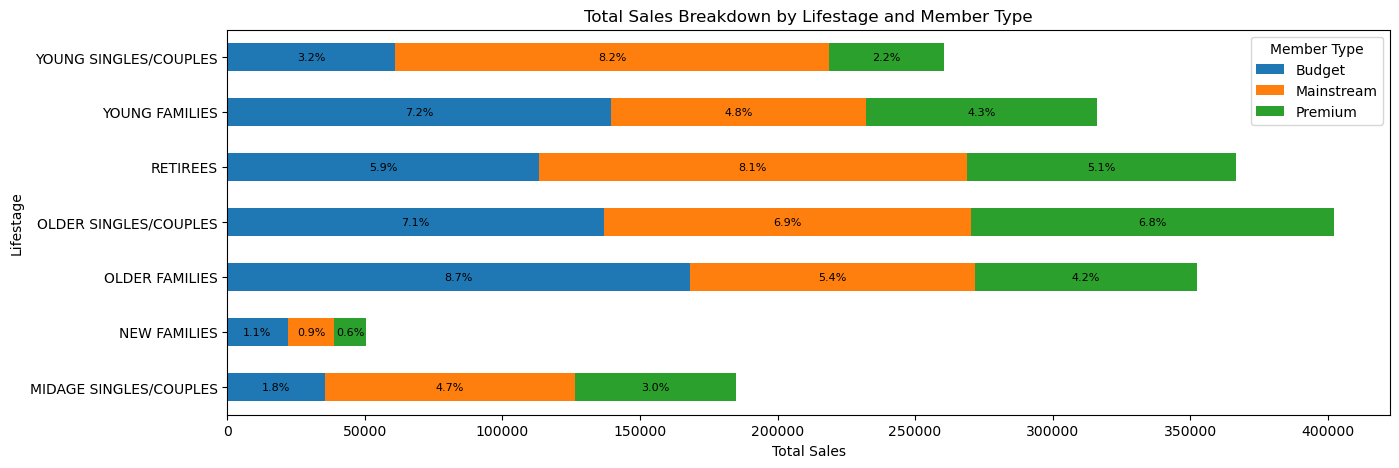

In [32]:
# Get the total sales 
total_sales = df['TOT_SALES'].agg(['sum'])['sum']

# Group by 'LIFESTAGE' and 'MEMBER_TYPE' and calculate the sum and mean of 'TOT_SALES'
total_sales_breakdown = df.groupby(['LIFESTAGE', 'MEMBER_TYPE'])['TOT_SALES'].agg(['sum', 'mean']).reset_index()

# Pivot the DataFrame to create a breakdown table
pivot_table = total_sales_breakdown.pivot_table(index='LIFESTAGE', columns='MEMBER_TYPE', values=['sum', 'mean'], fill_value=0)

# Plot the stacked bar chart
ax = pivot_table['sum'].plot(kind='barh', stacked=True, figsize=(15, 5))

# Add percentages of the summed total sales as labels to each bar 
# .patches is everything inside of the chart
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    label = width / total_sales * 100
    x = rect.get_x()
    y = rect.get_y()
    
    label_text = f'{(label):.1f}%' 
    
    # Set label positions
    label_x = x + width / 2
    label_y = y + height / 2
    
    # only plot labels greater than given width
    if width > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=8)

# Add labels and legend
plt.ylabel('Lifestage')
plt.xlabel('Total Sales')
plt.title('Total Sales Breakdown by Lifestage and Member Type')
plt.legend(title='Member Type', labels=pivot_table['sum'].columns)

# Show the plot
plt.show()


Most sales are from Older families - Budget, Young singles/couples - Mainstream and Retirees - Mainstream. 

In [33]:
# Check all rows are unique in customer information
print(len(PurBvr['LYLTY_CARD_NBR'].unique()) == PurBvr.shape[0])

# Check if all customers made chip purchases. 
len(PurBvr['LYLTY_CARD_NBR'].unique()) == len(df['LYLTY_CARD_NBR'].unique())

True


False

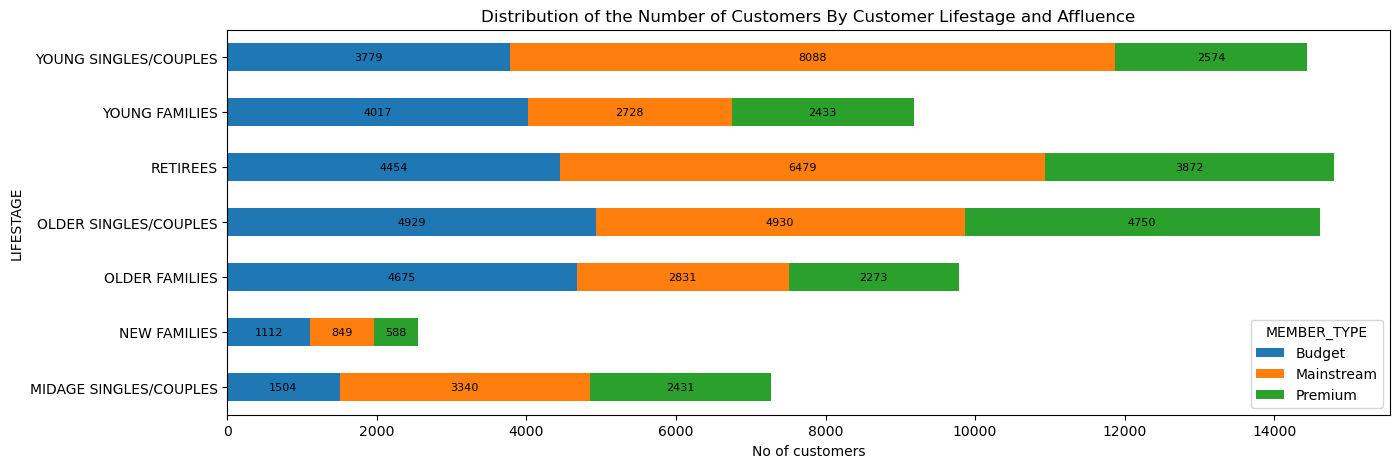

In [34]:
# Plot the numbers of customers in each segment by counting the unique LYLTY_CARD_NBR entries
sum_customers= df.groupby(['LIFESTAGE','MEMBER_TYPE'])['LYLTY_CARD_NBR'].agg('nunique').unstack('MEMBER_TYPE').fillna(0)
ax = sum_customers.plot(kind='barh', stacked=True, figsize=(15, 5))

# Add customer numbers as labels to each bar 
# .patches is everything inside of the chart
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    label_text = f'{(width):.0f}'
    
    # Set label positions
    label_x = x + width / 2
    label_y = y + height / 2
    
    # only plot labels greater than given width
    if width > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=8)
        
ax.set_xlabel("No of customers")
ax.set_title('Distribution of the Number of Customers By Customer Lifestage and Affluence')
plt.show()

More Young singles/couples - mainstream and Retirees - mainstream who buy chips. This indicate there will be more sales to these customer segments but this is not a major driver for the Older families - budget segment.

Let look at the total and average units of chips bought per customer by LIFESTAGE and MEMBER_TYPE.

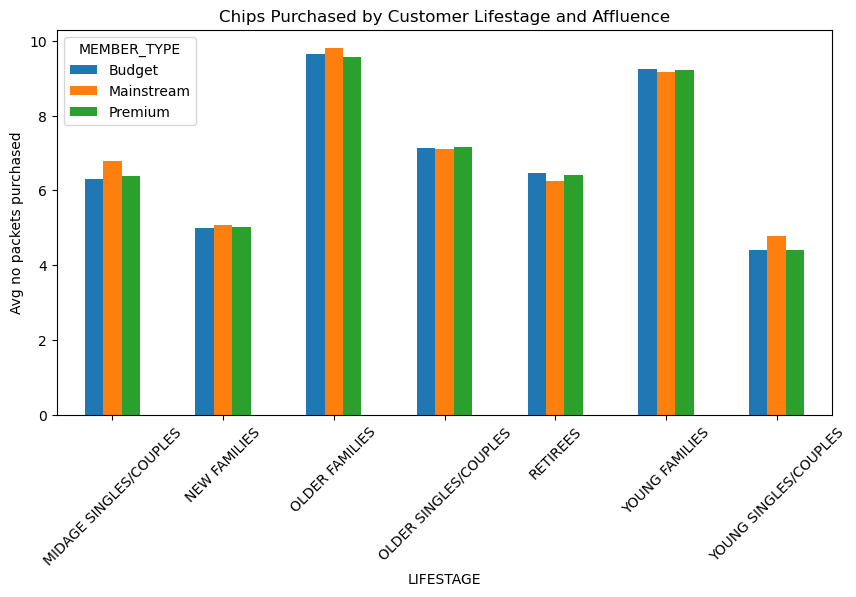

In [35]:
# Plot the average no of chip packets bought per customer by LIFESTAGE and MEMBER_TYPE.
no_packets_data = df.groupby(['LIFESTAGE','MEMBER_TYPE'])['PROD_QTY'].sum()/df.groupby(['LIFESTAGE','MEMBER_TYPE'])['LYLTY_CARD_NBR'].nunique(0)
ax = no_packets_data.unstack('MEMBER_TYPE').fillna(0).plot.bar(stacked = False,figsize=(10, 5))
ax.set_ylabel("Avg no packets purchased")
ax.set_title('Chips Purchased by Customer Lifestage and Affluence')
plt.xticks(rotation=45)
plt.show()

Older families and young families in general buy more chips per customer. We can also investigate the average price per unit sold by LIFESTAGE and MEMBER_TYPE.

In [36]:
 # Create a column for the unit price of chips purchased per transaction 
df['UNIT_PRICE'] = df['TOT_SALES']/df['PROD_QTY']

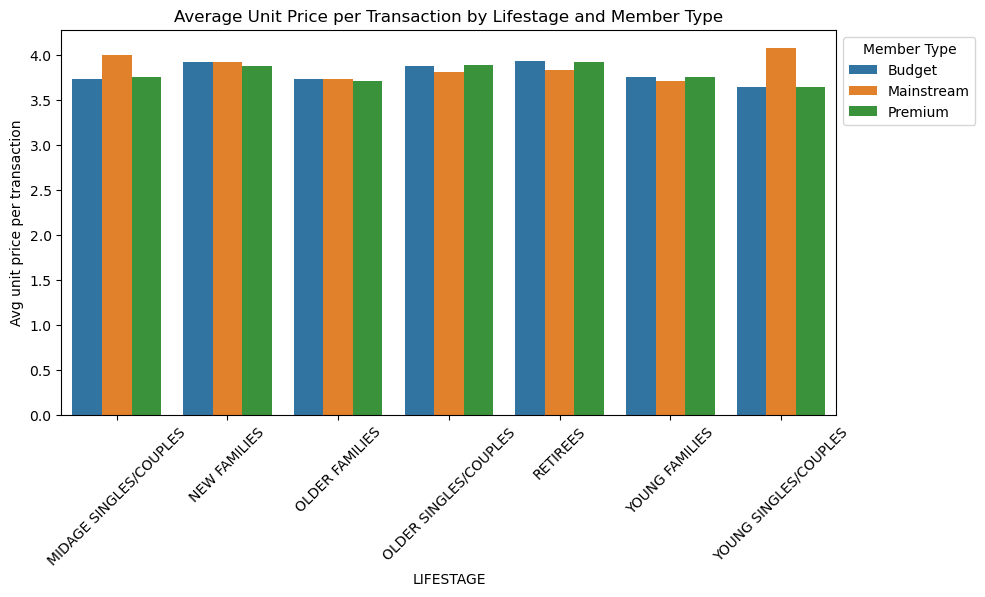

In [37]:
# Group by 'LIFESTAGE' and 'MEMBER_TYPE' and calculate the mean of 'UNIT_PRICE'
avg_price_per_unit = df.groupby(['LIFESTAGE', 'MEMBER_TYPE'])['UNIT_PRICE'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=avg_price_per_unit, x='LIFESTAGE', y='UNIT_PRICE', hue='MEMBER_TYPE')
ax.set_ylabel("Avg unit price per transaction")
ax.set_title("Average Unit Price per Transaction by Lifestage and Member Type")

# Show the plot
plt.xticks(rotation=45)
plt.legend(title='Member Type',loc = "upper left",bbox_to_anchor=(1.0, 1.0))
plt.show()


For young and midage singles/couples, the mainstream group are more willing to pay more for a packet of chips than their budget and premium counterpart. Given the total sales, as well as the number of customers buying chips, is higher in these groups compared to the non-mainstream groups, this suggests that chips may not be the choice of snack for these groups. Further information on shopping habits would be useful in this case.

As the difference in average price per unit isn’t large, we can check if this difference is statistically different, with a t-test.

In [38]:
from scipy.stats import ttest_ind
# Check the difference in the average price unit between the mainstream and premium/budget groups for young/midage singles/couples
# Identify the groups to test the hypthesis with 
mainstream = df["MEMBER_TYPE"] == "Mainstream"
young_midage = (df["LIFESTAGE"] == "MIDAGE SINGLES/COUPLES") | (df["LIFESTAGE"] == "YOUNG SINGLES/COUPLES")
premium_budget = df["MEMBER_TYPE"] != "Mainstream"

group1 = df[mainstream & young_midage]["UNIT_PRICE"]
group2 = df[premium_budget & young_midage]["UNIT_PRICE"]

# Generate the t-test 
stat, pval = ttest_ind(group1.values, group2.values, equal_var=False)

print(pval, stat)

0.0 40.60989476220132


The t-test results in a p-value is 0, indicates that the unit price for mainstream, young and mid-age singles and couples ARE significantly higher than that of budget or premium, young and midage singles and couples.

### Deep dive into specific customer segments for insights
We have found quite a few interesting insights so, We will want to target customer segments that contribute the most to sales to retain them or further increase sales. Let's look at Mainstream - young singles/couples. For instance, let's find out if they tend to buy a particular brand of chips.

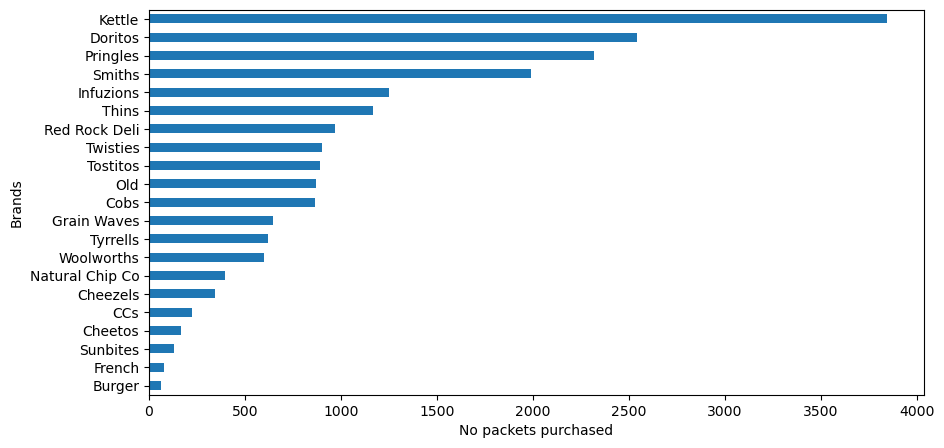

In [39]:
# Create a visual of what brands young singles/couples are purchasing the most for a general indication
young_mainstream = df.loc[df['LIFESTAGE'] == "YOUNG SINGLES/COUPLES"]
young_mainstream = young_mainstream.loc[young_mainstream['MEMBER_TYPE'] == "Mainstream"]
ax = young_mainstream["BRAND_NAME"].value_counts().sort_values(ascending = True).plot.barh(figsize=(10, 5))
ax.set_xlabel("No packets purchased")
ax.set_ylabel("Brands")
plt.show()

In [40]:
temp = df.copy()
temp["group"] = temp["LIFESTAGE"] + ' - ' + temp['MEMBER_TYPE']

In [41]:
groups = pd.get_dummies(temp["group"])
brands = pd.get_dummies(temp["BRAND_NAME"])
groups_brands = groups.join(brands)
groups_brands

,MIDAGE SINGLES/COUPLES - Budget,MIDAGE SINGLES/COUPLES - Mainstream,MIDAGE SINGLES/COUPLES - Premium,NEW FAMILIES - Budget,NEW FAMILIES - Mainstream,NEW FAMILIES - Premium,OLDER FAMILIES - Budget,OLDER FAMILIES - Mainstream,OLDER FAMILIES - Premium,OLDER SINGLES/COUPLES - Budget,...,Old,Pringles,Red Rock Deli,Smiths,Sunbites,Thins,Tostitos,Twisties,Tyrrells,Woolworths
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264829,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
264830,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
264831,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
264832,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [42]:
freq_groupsbrands = apriori(groups_brands, min_support=0.008, use_colnames=True)
rules = association_rules(freq_groupsbrands, metric="lift", min_threshold=0.5)
rules.sort_values('confidence', ascending = False, inplace = True)

In [43]:
set_temp = temp["group"].unique()
rules[rules["antecedents"].apply(lambda x: list(x)).apply(lambda x: x in set_temp)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
32,(YOUNG SINGLES/COUPLES - Mainstream),(Kettle),0.078744,0.155901,0.014515,0.184329,1.182344,0.002239,1.034852,0.167405
0,(MIDAGE SINGLES/COUPLES - Mainstream),(Kettle),0.044836,0.155901,0.008065,0.179889,1.153863,0.001075,1.029249,0.139605
16,(RETIREES - Budget),(Kettle),0.057398,0.155901,0.009787,0.170515,1.093737,0.000839,1.017618,0.090922
24,(RETIREES - Premium),(Kettle),0.049450,0.155901,0.008368,0.169212,1.085378,0.000658,1.016022,0.082754
9,(OLDER SINGLES/COUPLES - Budget),(Kettle),0.069504,0.155901,0.011573,0.166513,1.068064,0.000738,1.012731,0.068487
15,(OLDER SINGLES/COUPLES - Premium),(Kettle),0.067038,0.155901,0.011128,0.165991,1.064716,0.000676,1.012097,0.065150
20,(RETIREES - Mainstream),(Kettle),0.081055,0.155901,0.012785,0.157738,1.011779,0.000149,1.002180,0.012669
10,(OLDER SINGLES/COUPLES - Mainstream),(Kettle),0.069168,0.155901,0.010705,0.154766,0.992716,-0.000079,0.998656,-0.007821
26,(YOUNG FAMILIES - Budget),(Kettle),0.072204,0.155901,0.010357,0.143447,0.920116,-0.000899,0.985460,-0.085569
5,(OLDER FAMILIES - Budget),(Kettle),0.087451,0.155901,0.012536,0.143351,0.919495,-0.001098,0.985349,-0.087544


In [44]:
rules[rules['antecedents'] == {'YOUNG SINGLES/COUPLES - Mainstream'}]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
32,(YOUNG SINGLES/COUPLES - Mainstream),(Kettle),0.078744,0.155901,0.014515,0.184329,1.182344,0.002239,1.034852,0.167405
30,(YOUNG SINGLES/COUPLES - Mainstream),(Doritos),0.078744,0.106274,0.009595,0.121847,1.146536,0.001226,1.017734,0.138732
34,(YOUNG SINGLES/COUPLES - Mainstream),(Pringles),0.078744,0.094784,0.008741,0.111010,1.171189,0.001278,1.018252,0.158660


From apriori analysis, we can see that for Mainstream - young singles/couples, Kettle is the brand of choice. This is also true for most other segments. We can use the affinity index to see if there are brands this segment prefers more than the other segments to target.

In [45]:
# find the target rating proportion
target_segment = young_mainstream["BRAND_NAME"].value_counts().sort_values(ascending = True).rename_axis('BRANDS').reset_index(name='target')
target_segment.target /= young_mainstream["PROD_QTY"].sum()

# find the other rating proportion
not_young_mainstream = df.loc[df['LIFESTAGE'] != "YOUNG SINGLES/COUPLES"]
not_young_mainstream = not_young_mainstream.loc[not_young_mainstream['MEMBER_TYPE'] != "Mainstream"]
other = not_young_mainstream["BRAND_NAME"].value_counts().sort_values(ascending = True).rename_axis('BRANDS').reset_index(name='other')
other.other /= not_young_mainstream["PROD_QTY"].sum()

# join the two dataframes 
brand_proportions = target_segment.set_index('BRANDS').join(other.set_index('BRANDS'))
# df = TranData.set_index('LYLTY_CARD_NBR').join(PruBrv.set_index('LYLTY_CARD_NBR'))
brand_proportions = brand_proportions.reset_index()
brand_proportions['affinity'] = brand_proportions['target']/brand_proportions['other']
brand_proportions.sort_values(by = 'affinity', ascending = False)

,BRANDS,target,other,affinity
8,Tyrrells,0.016023,0.012459,1.286010
13,Twisties,0.023297,0.018298,1.273158
12,Tostitos,0.023038,0.018588,1.239370
11,Old,0.022443,0.018185,1.234108
20,Kettle,0.099503,0.080691,1.233133
18,Pringles,0.059924,0.048911,1.225166
19,Doritos,0.065774,0.054761,1.201124
10,Cobs,0.022365,0.018645,1.199512
16,Infuzions,0.032357,0.027897,1.159870
9,Grain Waves,0.016722,0.015112,1.106537


Using the affinity index, we can see that mainstream young singles/couples are 28% more likely to purchase Tyrrells chips than the other segments. However, they are 50% less likely to purchase Burger Rings.

We also want to find out if our target segment tends to buy larger packs of chips.

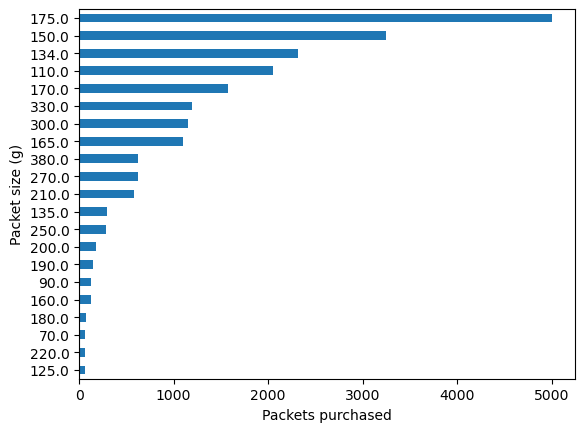

In [46]:
# Plot the distribution of the packet sizes for a general indication of what it most popular. 
young_mainstream = df.loc[df['LIFESTAGE'] == "YOUNG SINGLES/COUPLES"]
young_mainstream = young_mainstream.loc[young_mainstream['MEMBER_TYPE'] == "Mainstream"]
ax = young_mainstream["PACK_SIZE"].value_counts().sort_values(ascending = True).plot.barh()
ax.set_ylabel("Packet size (g)")
ax.set_xlabel("Packets purchased")
plt.show()

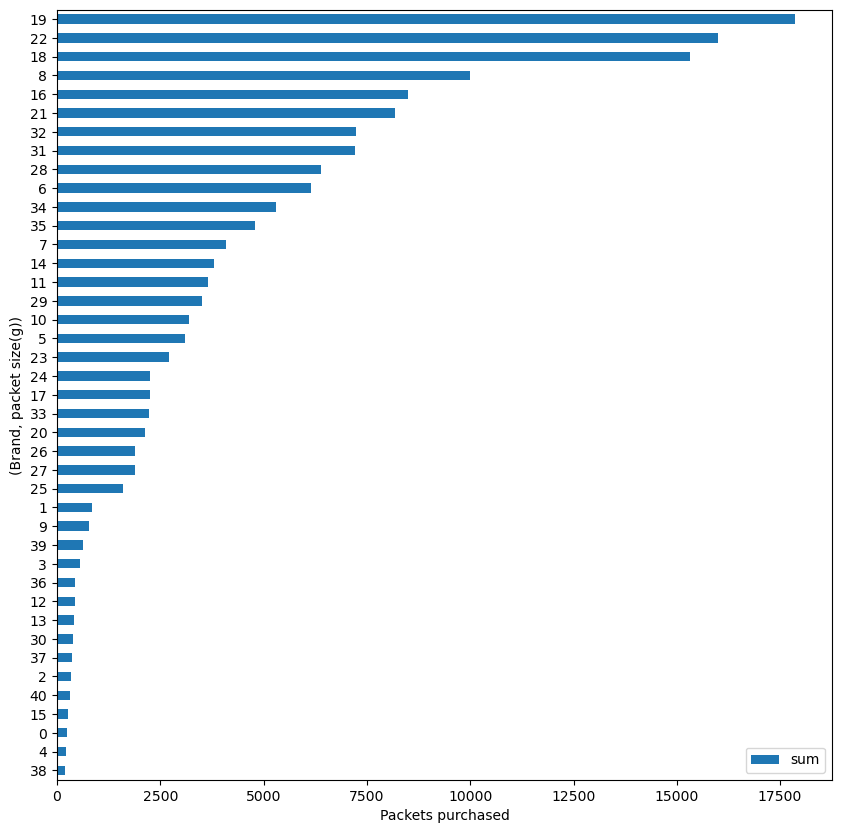

In [47]:
# Also want to check which brands correspond to what sized packets. 
brand_size = young_mainstream.groupby(['BRAND_NAME','PACK_SIZE'], as_index = False)['TOT_SALES'].agg(['sum'])
ax = brand_size.sort_values(by = 'sum').plot.barh(y = "sum", figsize=(10,10))
ax.set_ylabel("(Brand, packet size(g))")
ax.set_xlabel("Packets purchased")
plt.show()

In [48]:
groups = pd.get_dummies(temp["group"])
brands = pd.get_dummies(temp["PACK_SIZE"])
groups_brands = groups.join(brands)
groups_brands

,MIDAGE SINGLES/COUPLES - Budget,MIDAGE SINGLES/COUPLES - Mainstream,MIDAGE SINGLES/COUPLES - Premium,NEW FAMILIES - Budget,NEW FAMILIES - Mainstream,NEW FAMILIES - Premium,OLDER FAMILIES - Budget,OLDER FAMILIES - Mainstream,OLDER FAMILIES - Premium,OLDER SINGLES/COUPLES - Budget,...,180.0,190.0,200.0,210.0,220.0,250.0,270.0,300.0,330.0,380.0
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264829,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
264830,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
264831,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
264832,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [50]:
freq_groupsbrands = apriori(groups_brands, min_support=0.009, use_colnames=True)
rules = association_rules(freq_groupsbrands, metric="lift", min_threshold=0.5)
rules.sort_values('confidence', ascending = False, inplace = True)
set_temp = temp["group"].unique()
rules[rules["antecedents"].apply(lambda x: list(x)).apply(lambda x: x in set_temp)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
38,(YOUNG FAMILIES - Premium),(175.0),0.043661,0.250685,0.011320,0.259275,1.034266,0.000375,1.011597,0.034643
34,(YOUNG FAMILIES - Budget),(175.0),0.072204,0.250685,0.018581,0.257348,1.026576,0.000481,1.008971,0.027903
24,(RETIREES - Budget),(175.0),0.057398,0.250685,0.014526,0.253075,1.009534,0.000137,1.003200,0.010019
30,(RETIREES - Premium),(175.0),0.049450,0.250685,0.012483,0.252443,1.007013,0.000087,1.002352,0.007327
6,(OLDER FAMILIES - Mainstream),(175.0),0.053785,0.250685,0.013548,0.251896,1.004828,0.000065,1.001618,0.005077
8,(OLDER FAMILIES - Premium),(175.0),0.042253,0.250685,0.010633,0.251653,1.003861,0.000041,1.001293,0.004016
12,(OLDER SINGLES/COUPLES - Budget),(175.0),0.069504,0.250685,0.017464,0.251263,1.002305,0.000040,1.000772,0.002471
20,(OLDER SINGLES/COUPLES - Premium),(175.0),0.067038,0.250685,0.016833,0.251098,1.001648,0.000028,1.000551,0.001763
4,(OLDER FAMILIES - Budget),(175.0),0.087451,0.250685,0.021931,0.250777,1.000366,0.000008,1.000123,0.000401
0,(MIDAGE SINGLES/COUPLES - Mainstream),(175.0),0.044836,0.250685,0.011233,0.250547,0.999450,-0.000006,0.999816,-0.000576


While it appears that most segments purchase more chip packets that are 175g, which is also the size that most Kettles chips are purchased in, we can also determine whether mainstream young singles/couples have certain preferences over the other segments again using the affinity index.

In [51]:
# find the target rating proportion
target_segment = young_mainstream["PACK_SIZE"].value_counts().sort_values(ascending = True).rename_axis('SIZES').reset_index(name='target')
target_segment.target /= young_mainstream["PROD_QTY"].sum()

# find the other rating proportion
other = not_young_mainstream["PACK_SIZE"].value_counts().sort_values(ascending = True).rename_axis('SIZES').reset_index(name='other')
other.other /= not_young_mainstream["PROD_QTY"].sum()

# join the two dataframes 
brand_proportions = target_segment.set_index('SIZES').join(other.set_index('SIZES'))
brand_proportions = brand_proportions.reset_index()
brand_proportions['affinity'] = brand_proportions['target']/brand_proportions['other']
brand_proportions.sort_values(by = 'affinity', ascending = False)

,SIZES,target,other,affinity
11,270.0,0.016049,0.012078,1.328823
12,380.0,0.016204,0.012467,1.299815
15,330.0,0.030933,0.024657,1.254517
10,210.0,0.014910,0.012092,1.233075
18,134.0,0.059924,0.048911,1.225166
17,110.0,0.053091,0.043483,1.220965
9,135.0,0.007507,0.006292,1.193131
8,250.0,0.007248,0.006221,1.165087
16,170.0,0.040769,0.038984,1.045796
14,300.0,0.029742,0.029640,1.003438


Here, we can see that mainstream young singles/couples are 32% more likely to purcahse 270g chips than the other segments. However, they are 50% less likely to purchase 220g chips. The chips that come in 270g bags are Twisties while Burger Rings come in 220g bags, which is consistent with the affinity testing for the chip brands.

#### Summary of Insights
The three highest contributing segments to the total sales are:

**Older families - Budget** -$168,363 

**Young singles/couples - Mainstream** -$157,621 

**Retirees - Mainstream** - $155,677   

1. Young Singles/Couples (Mainstream) has the highest population, followed by Retirees (Mainstream). Which explains their high total sales.

2. Despite Older Families not having the highest population, they have the highest frequency of purchase, which contributes to their high total sales.

3. Older Families followed by Young Families has the highest average quantity of chips bought per purchase.

4. The Mainstream category of the "Young and Midage Singles/Couples" have the highest spending of chips per purchase. And the difference to the non-Mainstream "Young and Midage Singles/Couples" are statistically significant.

5. Chips brand Kettle is dominating every segment as the most purchased brand.

6. Observing the 2nd most purchased brand, "Young and Midage Singles/Couples" is the only segment with a different preference (Doritos) as compared to others' (Smiths).

7. Most frequent chip size purchased is 175gr followed by the 150gr chip size for all segments.

#### Recommendations:

1. Older Families:
Focus on the Budget segment.
Strength: Frequent purchase. We can give promotions that encourages more frequency of purchase.
Strength: High quantity of chips purchased per visit. We can give promotions that encourage them to buy more quantity of chips per purchase.

2. Young Singles/Couples:
Focus on the Mainstream segment.
This segment is the only segment that had Doritos as their 2nd most purchased brand (after Kettle). To specifically target this segment it might be a good idea to collaborate with Doritos merchant to do some branding promotion catered to "Young Singles/Couples - Mainstream" segment.
Strength: Population quantity. We can spend more effort on making sure our promotions reach them, and it reaches them frequently.

3. Retirees:
Focus on the Mainstream segment.
Strength: Population quantity. Again, since their population quantity is the contributor to the high total sales, we should spend more effort on making sure our promotions reaches as many of them as possible and frequent.

4. General:
All segments has Kettle as the most frequently purchased brand, and 175gr (regardless of brand) followed by 150gr as the preferred chip size.
When promoting chips in general to all segments it is good to take advantage of these two points.
